In [64]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics

In [65]:
#Download data for csv from https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
#Unzip file and save the covtype.data as covtype.csv
#Placing file into gitignore since it is a large one
covtype = pd.read_csv('covtype.csv',delimiter=',',dtype='float32').values

In [66]:
#First 54 columns are features and last column is the label
covtype.shape

(581011, 55)

In [67]:
covtype_features,covtype_labels = covtype[:,:54],covtype[:,54]

In [68]:
#Subtract 1 each from the covtype_labels to make them into 0 index data (i.e. from 1 to 10 transformed to 0 to 9)
covtype_labels -= 1

In [71]:
np.random.seed(0) #Start shuffle seed
train_features,test_features,train_labels,test_labels = train_test_split(covtype_features,covtype_labels,test_size=0.15)

In [72]:
#Confirmation of split of data between Train and Test
totaldata= train_features.shape[0]+test_features.shape[0]
datasetsplit = (train_features.shape[0]/totaldata,test_features.shape[0]/totaldata)
datasetsplit

(0.8499993976017666, 0.15000060239823343)

In [73]:
# assign label names and count label frequencies
label_map = {0:'Spruce/Fir', 1:'Lodgepole Pine', 2:'Ponderosa Pine', 3:'Cottonwood/Willow', 
             4:'Aspen', 5:'Douglas-fir', 6:'Krummholz'}

<AxesSubplot:title={'center':'Label Counts'}>

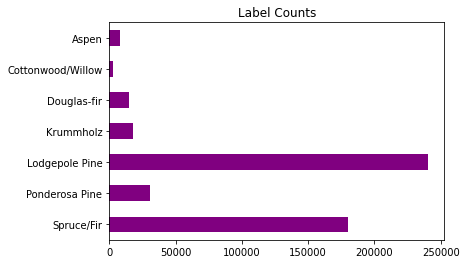

In [74]:
label_counts = pd.DataFrame(data=train_labels)[0].map(label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot(kind='barh', color='purple', title='Label Counts')

In [75]:
%%time
#Train the model using 'One vs rest' classifier
lm = linear_model.LogisticRegressionCV(cv=5,multi_class='ovr', solver='liblinear')
lm.fit(train_features, train_labels)

Wall time: 56min 13s


LogisticRegressionCV(cv=5, multi_class='ovr', solver='liblinear')

In [80]:
# Test on a random test row. In this example the 300th row was chosen
print('Predicted value is : {}'.format(lm.predict([test_features[2000,:]])[0]))
print('Actual value is : {}'.format(test_labels[2000]))

Predicted value is : 1.0
Actual value is : 0.0


In [84]:
#Calculate percentage of accurate predictions on test set
accuracy = lm.score(test_features,test_labels)
print("Accuracy is : {} %".format(accuracy*100))

Accuracy is : 71.03221957040573 %


In [85]:
print(metrics.classification_report(test_labels, lm.predict(test_features)))

              precision    recall  f1-score   support

         0.0       0.70      0.67      0.69     31617
         1.0       0.73      0.81      0.77     42636
         2.0       0.61      0.86      0.72      5326
         3.0       0.64      0.23      0.34       413
         4.0       0.00      0.00      0.00      1432
         5.0       0.40      0.05      0.08      2621
         6.0       0.78      0.42      0.54      3107

    accuracy                           0.71     87152
   macro avg       0.55      0.43      0.45     87152
weighted avg       0.69      0.71      0.69     87152



c:\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))